In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons
!pip install patchify

In [ ]:
import os
import glob
import random
import cv2
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Activation, Add, GlobalAveragePooling2D, Reshape, Dense, multiply, Permute, maximum, Concatenate, Multiply
from keras import backend as K
from keras import metrics
from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
image_names = glob.glob('/content/drive/MyDrive/train_img/*.png')
image_names.sort()
images = [cv2.imread(img, 0) for img in image_names]
image_dataset = np.array(images)
print(len(image_dataset))
image_dataset = np.expand_dims(image_dataset, axis=3)
print(len(image_dataset))

2260
2260


In [ ]:
mask_names = glob.glob('/content/drive/MyDrive/train_mask/*.png')
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)
print(len(mask_dataset))

2260


In [ ]:
image_dataset = image_dataset / 255.
mask_dataset = mask_dataset / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

1808 452


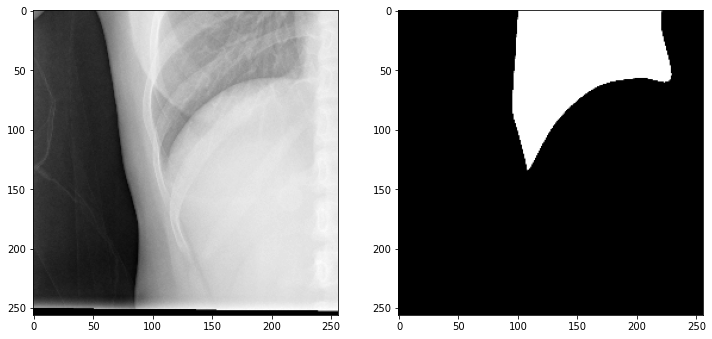

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
"""# **Preparing the Model**"""

def base_unet(filters, output_channels, width=None, height=None, input_channels=1, conv_layers=2):
    def conv2d(layer_input, filters, conv_layers=2):
        d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer_input)
        d = BatchNormalization()(d)
        d = Activation('relu')(d)

        for i in range(conv_layers - 1):
            d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(d)
            d = BatchNormalization()(d)
            d = Activation('relu')(d)

        return d

    def deconv2d(layer_input, filters):
        u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
        u = BatchNormalization()(u)
        u = Activation('relu')(u)
        return u

    inputs = Input(shape=(width, height, input_channels))

    conv1 = conv2d(inputs, filters, conv_layers=conv_layers)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = conv2d(pool1, filters * 2, conv_layers=conv_layers)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = conv2d(pool2, filters * 4, conv_layers=conv_layers)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = conv2d(pool3, filters * 8, conv_layers=conv_layers)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = conv2d(pool4, filters * 16, conv_layers=conv_layers)

    up6 = deconv2d(conv5, filters * 8)
    up6 = Concatenate()([up6, conv4])
    conv6 = conv2d(up6, filters * 8, conv_layers=conv_layers)

    up7 = deconv2d(conv6, filters * 4)
    up7 = Concatenate()([up7, conv3])
    conv7 = conv2d(up7, filters * 4, conv_layers=conv_layers)

    up8 = deconv2d(conv7, filters * 2)
    up8 = Concatenate()([up8, conv2])
    conv8 = conv2d(up8, filters * 2, conv_layers=conv_layers)

    up9 = deconv2d(conv8, filters)
    up9 = Concatenate()([up9, conv1])
    conv9 = conv2d(up9, filters, conv_layers=conv_layers)

    # Changed sigmoid to sigmoid, also changed output from 1 to 4
    outputs = Conv2D(output_channels, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model


def attention_unet(filters, output_channels, width=None, height=None, input_channels=1, conv_layers=2):
    def conv2d(layer_input, filters, conv_layers=2):
        d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer_input)
        d = BatchNormalization()(d)
        d = Activation('relu')(d)

        for i in range(conv_layers - 1):
            d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(d)
            d = BatchNormalization()(d)
            d = Activation('relu')(d)

        return d

    def deconv2d(layer_input, filters):
        u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
        u = BatchNormalization()(u)
        u = Activation('relu')(u)
        return u

    def attention_block(F_g, F_l, F_int):
        g = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_g)
        g = BatchNormalization()(g)
        x = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_l)
        x = BatchNormalization()(x)
        psi = Add()([g, x])
        psi = Activation('relu')(psi)

        psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(psi)
        psi = Activation('sigmoid')(psi)

        return Multiply()([F_l, psi])

    inputs = Input(shape=(width, height, input_channels))

    conv1 = conv2d(inputs, filters, conv_layers=conv_layers)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = conv2d(pool1, filters * 2, conv_layers=conv_layers)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = conv2d(pool2, filters * 4, conv_layers=conv_layers)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = conv2d(pool3, filters * 8, conv_layers=conv_layers)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = conv2d(pool4, filters * 16, conv_layers=conv_layers)

    up6 = deconv2d(conv5, filters * 8)
    conv6 = attention_block(up6, conv4, filters * 8)
    up6 = Concatenate()([up6, conv6])
    conv6 = conv2d(up6, filters * 8, conv_layers=conv_layers)

    up7 = deconv2d(conv6, filters * 4)
    conv7 = attention_block(up7, conv3, filters * 4)
    up7 = Concatenate()([up7, conv7])
    conv7 = conv2d(up7, filters * 4, conv_layers=conv_layers)

    up8 = deconv2d(conv7, filters * 2)
    conv8 = attention_block(up8, conv2, filters * 2)
    up8 = Concatenate()([up8, conv8])
    conv8 = conv2d(up8, filters * 2, conv_layers=conv_layers)

    up9 = deconv2d(conv8, filters)
    conv9 = attention_block(up9, conv1, filters)
    up9 = Concatenate()([up9, conv9])
    conv9 = conv2d(up9, filters, conv_layers=conv_layers)

    outputs = Conv2D(output_channels, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model


def dense_unet(filters, output_channels, width=None, height=None, input_channels=1, conv_layers=2):
    def conv2d(layer_input, filters, conv_layers=2):
        concats = []

        d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer_input)
        d = BatchNormalization()(d)
        d = Activation('relu')(d)

        concats.append(d)
        M = d

        for i in range(conv_layers - 1):
            d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(M)
            d = BatchNormalization()(d)
            d = Activation('relu')(d)

            concats.append(d)
            M = concatenate(concats)

        return M

    def deconv2d(layer_input, filters):
        u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
        u = BatchNormalization()(u)
        u = Activation('relu')(u)
        return u

    inputs = Input(shape=(width, height, input_channels))

    conv1 = conv2d(inputs, filters, conv_layers=conv_layers)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv2d(pool1, filters * 2, conv_layers=conv_layers)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv2d(pool2, filters * 4, conv_layers=conv_layers)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv2d(pool3, filters * 8, conv_layers=conv_layers)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv2d(pool4, filters * 16, conv_layers=conv_layers)

    up6 = deconv2d(conv5, filters * 8)
    merge6 = concatenate([conv4, up6])
    conv6 = conv2d(merge6, filters * 8, conv_layers=conv_layers)

    up7 = deconv2d(conv6, filters * 4)
    merge7 = concatenate([conv3, up7])
    conv7 = conv2d(merge7, filters * 4, conv_layers=conv_layers)

    up8 = deconv2d(conv7, filters * 2)
    merge8 = concatenate([conv2, up8])
    conv8 = conv2d(merge8, filters * 2, conv_layers=conv_layers)

    up9 = deconv2d(conv8, filters)
    merge9 = concatenate([conv1, up9])
    conv9 = conv2d(merge9, filters, conv_layers=conv_layers)

    outputs = Conv2D(output_channels, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def dense_attention_unet(filters, output_channels, width=None, height=None, input_channels=1, conv_layers=2):
    def conv2d(layer_input, filters, conv_layers=2):
        concats = []

        d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer_input)
        d = BatchNormalization()(d)
        d = Activation('relu')(d)

        concats.append(d)
        M = d

        for i in range(conv_layers - 1):
            d = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(M)
            d = BatchNormalization()(d)
            d = Activation('relu')(d)

            concats.append(d)
            M = concatenate(concats)

        return M

    def deconv2d(layer_input, filters):
        u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
        u = BatchNormalization()(u)
        u = Activation('relu')(u)
        return u

    def attention_block(F_g, F_l, F_int):
        g = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_g)
        g = BatchNormalization()(g)
        x = Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_l)
        x = BatchNormalization()(x)
        psi = Add()([g, x])
        psi = Activation('relu')(psi)

        psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(psi)
        psi = Activation('sigmoid')(psi)

        return Multiply()([F_l, psi])

    inputs = Input(shape=(width, height, input_channels))

    conv1 = conv2d(inputs, filters, conv_layers=conv_layers)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv2d(pool1, filters * 2, conv_layers=conv_layers)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv2d(pool2, filters * 4, conv_layers=conv_layers)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv2d(pool3, filters * 8, conv_layers=conv_layers)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv2d(pool4, filters * 16, conv_layers=conv_layers)


    up6 = deconv2d(conv5, filters * 8)
    conv6 = attention_block(up6, conv4, filters * 8)
    up6 = Concatenate()([up6, conv6])
    conv6 = conv2d(up6, filters * 8, conv_layers=conv_layers)

    up7 = deconv2d(conv6, filters * 4)
    conv7 = attention_block(up7, conv3, filters * 4)
    up7 = Concatenate()([up7, conv7])
    conv7 = conv2d(up7, filters * 4, conv_layers=conv_layers)

    up8 = deconv2d(conv7, filters * 2)
    conv8 = attention_block(up8, conv2, filters * 2)
    up8 = Concatenate()([up8, conv8])
    conv8 = conv2d(up8, filters * 2, conv_layers=conv_layers)

    up9 = deconv2d(conv8, filters)
    conv9 = attention_block(up9, conv1, filters)
    up9 = Concatenate()([up9, conv9])
    conv9 = conv2d(up9, filters, conv_layers=conv_layers)

    outputs = Conv2D(output_channels, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
model = unetpp(16, 1, width=256, height=256, input_channels=1)
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=dice_coef_loss, metrics=['accuracy', dice_coef, metrics.BinaryIoU(threshold=0.75)])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
57/57 [==============================] - 74s 949ms/step - loss: 0.4985 - accuracy: 0.7002 - dice_coef: 0.5020 - binary_io_u: 0.5801 - val_loss: 0.6414 - val_accuracy: 0.3027 - val_dice_coef: 0.3609 - val_binary_io_u: 0.3729
Epoch 2/50
57/57 [==============================] - 48s 839ms/step - loss: 0.2850 - accuracy: 0.9138 - dice_coef: 0.7149 - binary_io_u: 0.8555 - val_loss: 0.6008 - val_accuracy: 0.2541 - val_dice_coef: 0.4022 - val_binary_io_u: 0.2495
Epoch 3/50
57/57 [==============================] - 49s 852ms/step - loss: 0.1957 - accuracy: 0.9680 - dice_coef: 0.8039 - binary_io_u: 0.9268 - val_loss: 0.6059 - val_accuracy: 0.2541 - val_dice_coef: 0.3970 - val_binary_io_u: 0.3537
Epoch 4/50
57/57 [==============================] - 49s 861ms/step - loss: 0.1714 - accuracy: 0.9723 - dice_coef: 0.8282 - binary_io_u: 0.9357 - val_loss: 0.6088 - val_accuracy: 0.7062 - val_dice_coef: 0.3940 - val_binary_io_u: 0.3775
Epoch 5/50
57/57 [==============================] - 51s 891m

In [ ]:
model.save('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet.hdf5')

Parameters: 2054065

Accuracy: 97.46%
Dice Coefficient: 94.14%
IoU: 93.79%


evaluation:
<built-in function eval>


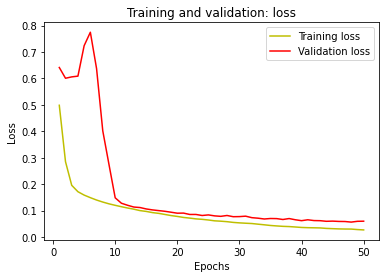

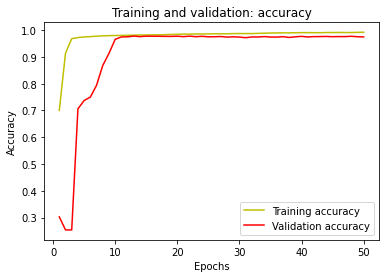

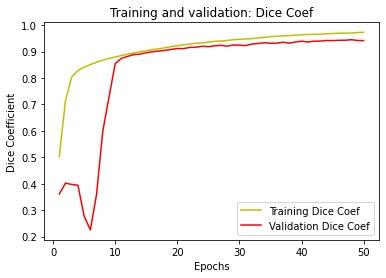

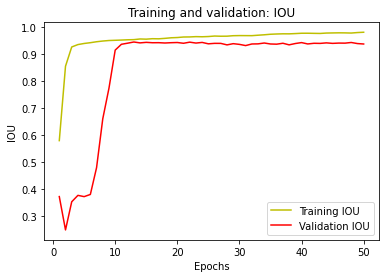

In [ ]:
# print("\n\nModel:", model_name)
print("Parameters:", model.count_params())
print(f"\nAccuracy: {float(np.round((history.history['val_accuracy'][-1])*100, 2))}%")
print(f"Dice Coefficient: {float(np.round((history.history['val_dice_coef'][-1])*100, 2))}%")
# print(f"F1-score: {float(np.round((history.history['val_f1_score'][-1])*100, 2))}%")
print(f"IoU: {float(np.round((history.history['val_binary_io_u'][-1]) * 100, 2))}%\n\n")

print("evaluation:")
print(eval)
open('/content/drive/MyDrive/result6_16filter_batch32_0.0001/train_log.txt', 'w').close()
pd.DataFrame.from_dict(model.history.history).to_csv('/content/drive/MyDrive/result6_16filter_batch32_0.0001/history.csv', index=False)

loss = history.history['loss']
val_loss = history.history['val_loss']
epo = range(1, len(loss) + 1)
plt.plot(epo, loss, 'y', label='Training loss')
plt.plot(epo, val_loss, 'r', label='Validation loss')
plt.title('Training and validation: loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet/training_validation_loss.png')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epo, acc, 'y', label='Training accuracy')
plt.plot(epo, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation: accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet/training_validation_accuracy.png')
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
plt.plot(epo, acc, 'y', label='Training Dice Coef')
plt.plot(epo, val_acc, 'r', label='Validation Dice Coef')
plt.title('Training and validation: Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet/training_validation_dice_coef.png')
plt.show()

acc = history.history['binary_io_u']
val_acc = history.history['val_binary_io_u']
plt.plot(epo, acc, 'y', label='Training IOU')
plt.plot(epo, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation: IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet/training_validation_iou.png')
plt.show()


1/1 [==============================] - 1s 860ms/step


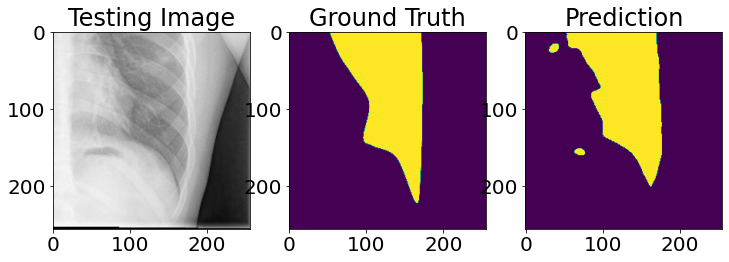

<Figure size 432x288 with 0 Axes>

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.75).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth[:, :, 0])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()
plt.savefig('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet/prediction.png')

In [ ]:
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
large_image = cv2.imread('/content/drive/MyDrive/result/image/CHNCXR_0001_0.png', 0)
patches = patchify(large_image, (256, 256), step=256)

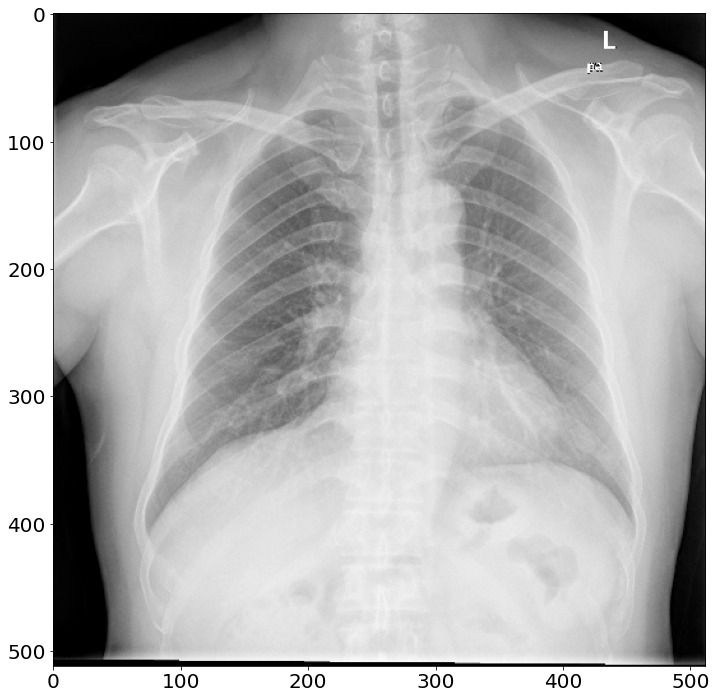

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(large_image, cmap='gray')

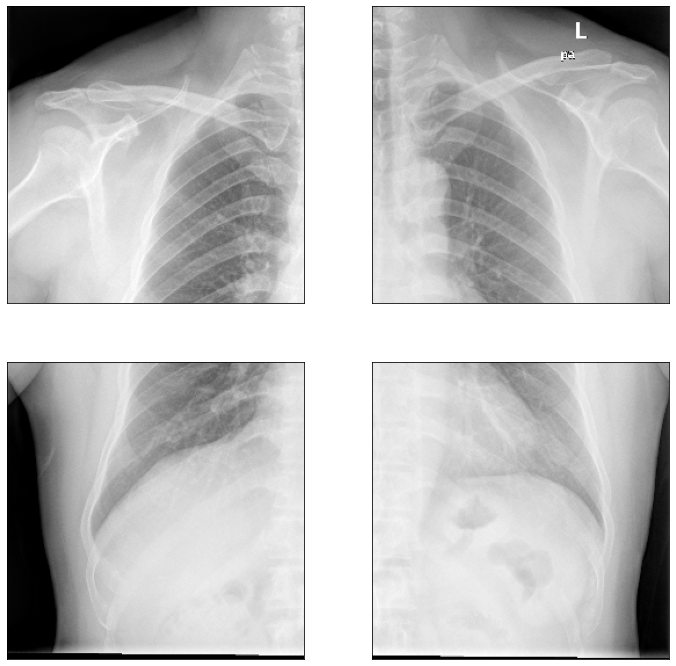

In [ ]:
plt.figure(figsize=(12, 12))
square = 2
ix = 1

for i in range(square):
	for j in range(square):
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])

		plt.imshow(patches[i, j, :, :], cmap='gray')
		ix += 1

plt.show()

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/result6_16filter_batch32_0.0001/attention_unet.hdf5', compile=False)

In [ ]:
threshold = 0.75
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i,j,:,:]
        single_patch = single_patch / 255.
        single_patch_input = np.expand_dims(single_patch, 0)

        single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 256,256) )

1/1 [==============================] - 0s 23ms/step


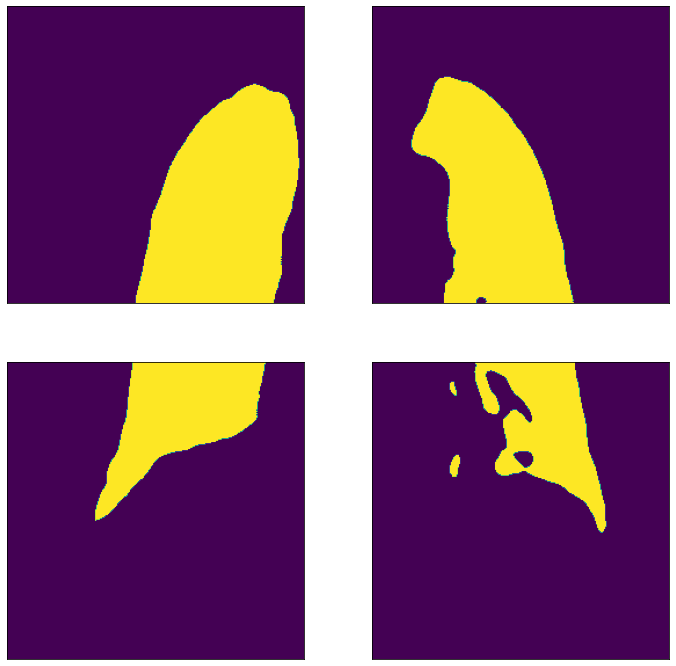

In [ ]:
plt.figure(figsize=(12, 12))
square = 2
ix = 1

for i in range(square):
	for j in range(square):
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(predicted_patches_reshaped[i, j, :, :])
		ix += 1

plt.show()

In [ ]:
reconstructed_image_base_unet = unpatchify(predicted_patches_reshaped, large_image.shape)

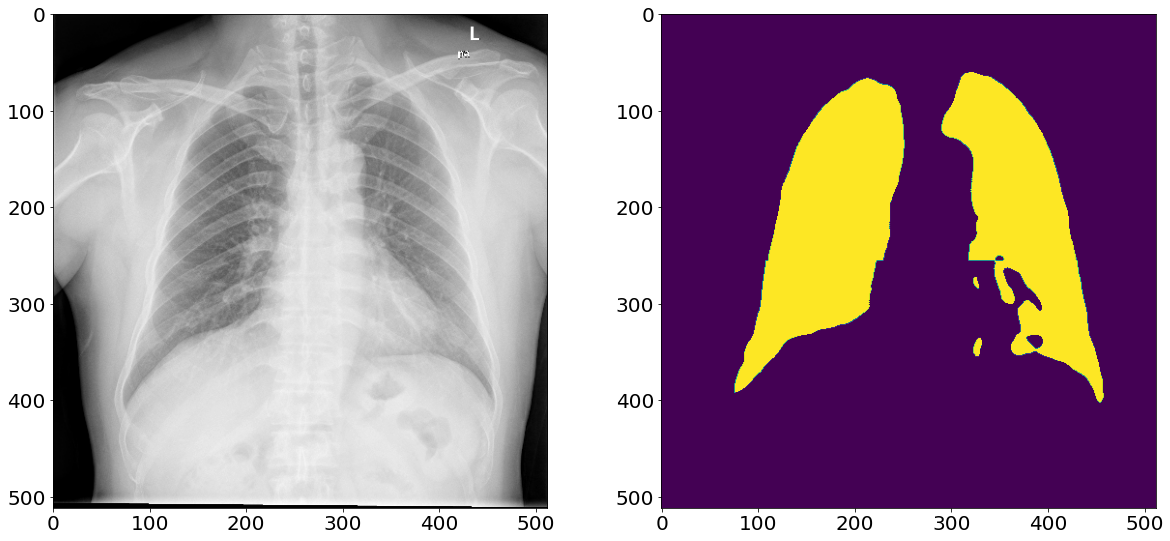

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(221)
# plt.title('Large Image')
plt.imshow(large_image, cmap='gray')

plt.subplot(222)
# plt.title('Prediction of base_unet')
plt.imshow(reconstructed_image_base_unet)

plt.savefig('/content/drive/MyDrive/auvy dr kaj/shenzen/result6_16filter_batch32_0.0001/unetpp/final_prediction.png')
plt.show()